## Stitch HCA_F_RepTsp13902013 & HCA_F_RepTsp13902014 (Uterovaginal canal)

In [1]:
import scanpy as sc

sc.settings.set_figure_params(figsize=(8,8))

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

### 1. Read in concatenated anndata object and select spots covered by tissue

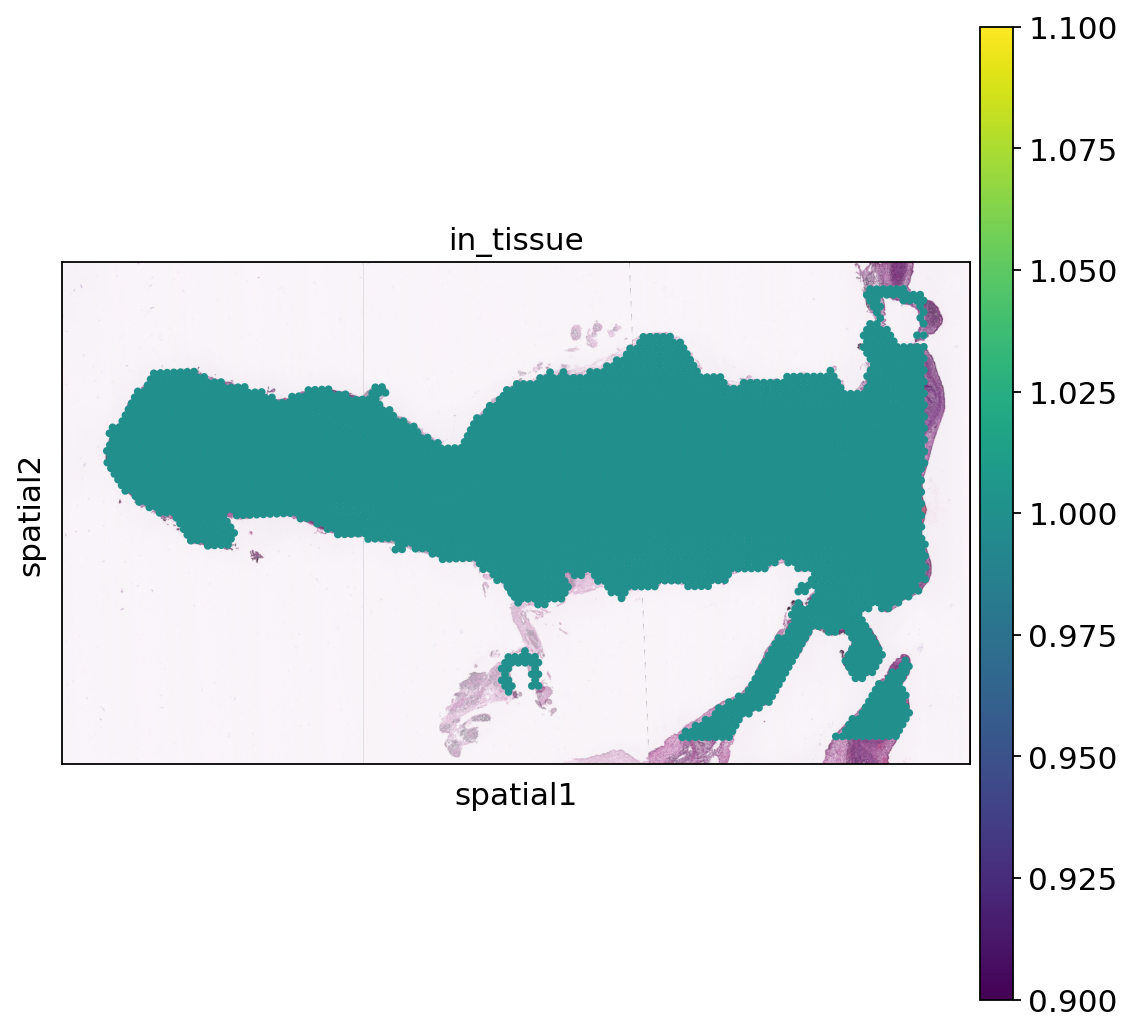

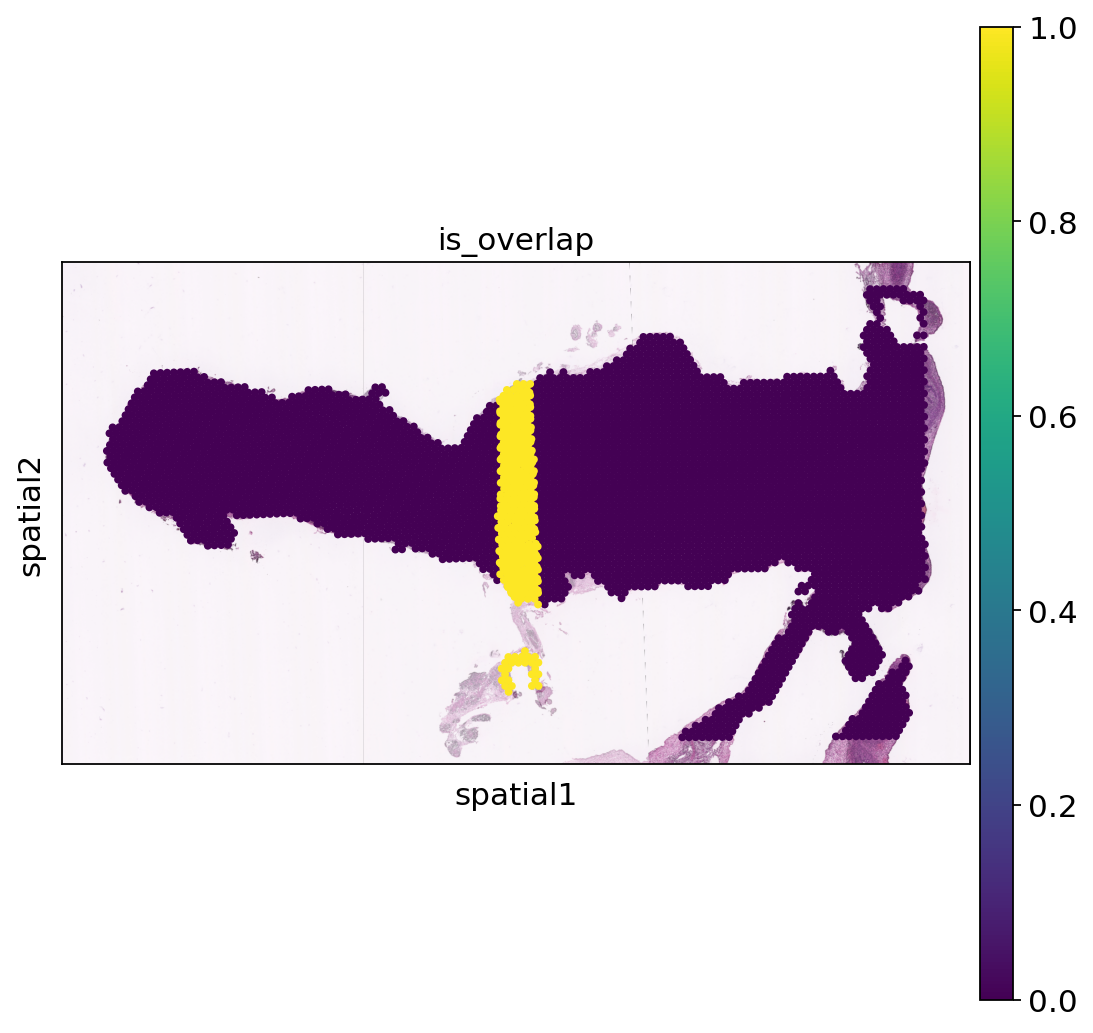

In [3]:
adata = sc.read('HCA_F_RepTsp13902013_14_joint.h5ad')
adata = adata[adata.obs['in_tissue'] == 1]
sc.pl.spatial(adata, color="in_tissue")
sc.pl.spatial(adata, color="is_overlap")


### 2. Use the overlapping spots to assess differences in sequencing depth 

In [4]:
adata.var['SYMBOL'] = adata.var_names
adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
adata.var_names = adata.var['ENSEMBL']
adata.var.drop(columns='ENSEMBL', inplace=True)

/tmp/ipykernel_45053/2200776127.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['SYMBOL'] = adata.var_names


In [5]:
overlap = adata[[i == 1 for i in adata.obs['is_overlap']]]
overlap

View of AnnData object with n_obs × n_vars = 407 × 37082
    obs: 'sample', 'batch', 'in_tissue', 'array_row', 'array_col', 'overlaps_with', 'is_overlap', 'in_tissue_and_is_overlap'
    var: 'feature_types', 'genome', 'SYMBOL'
    uns: 'sample_colors', 'spatial'
    obsm: 'spatial'

In [6]:
sc.pp.filter_genes(overlap, min_cells=5) 

/opt/conda/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [7]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(overlap, inplace=True)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='n_genes_by_counts', ylabel='Count'>

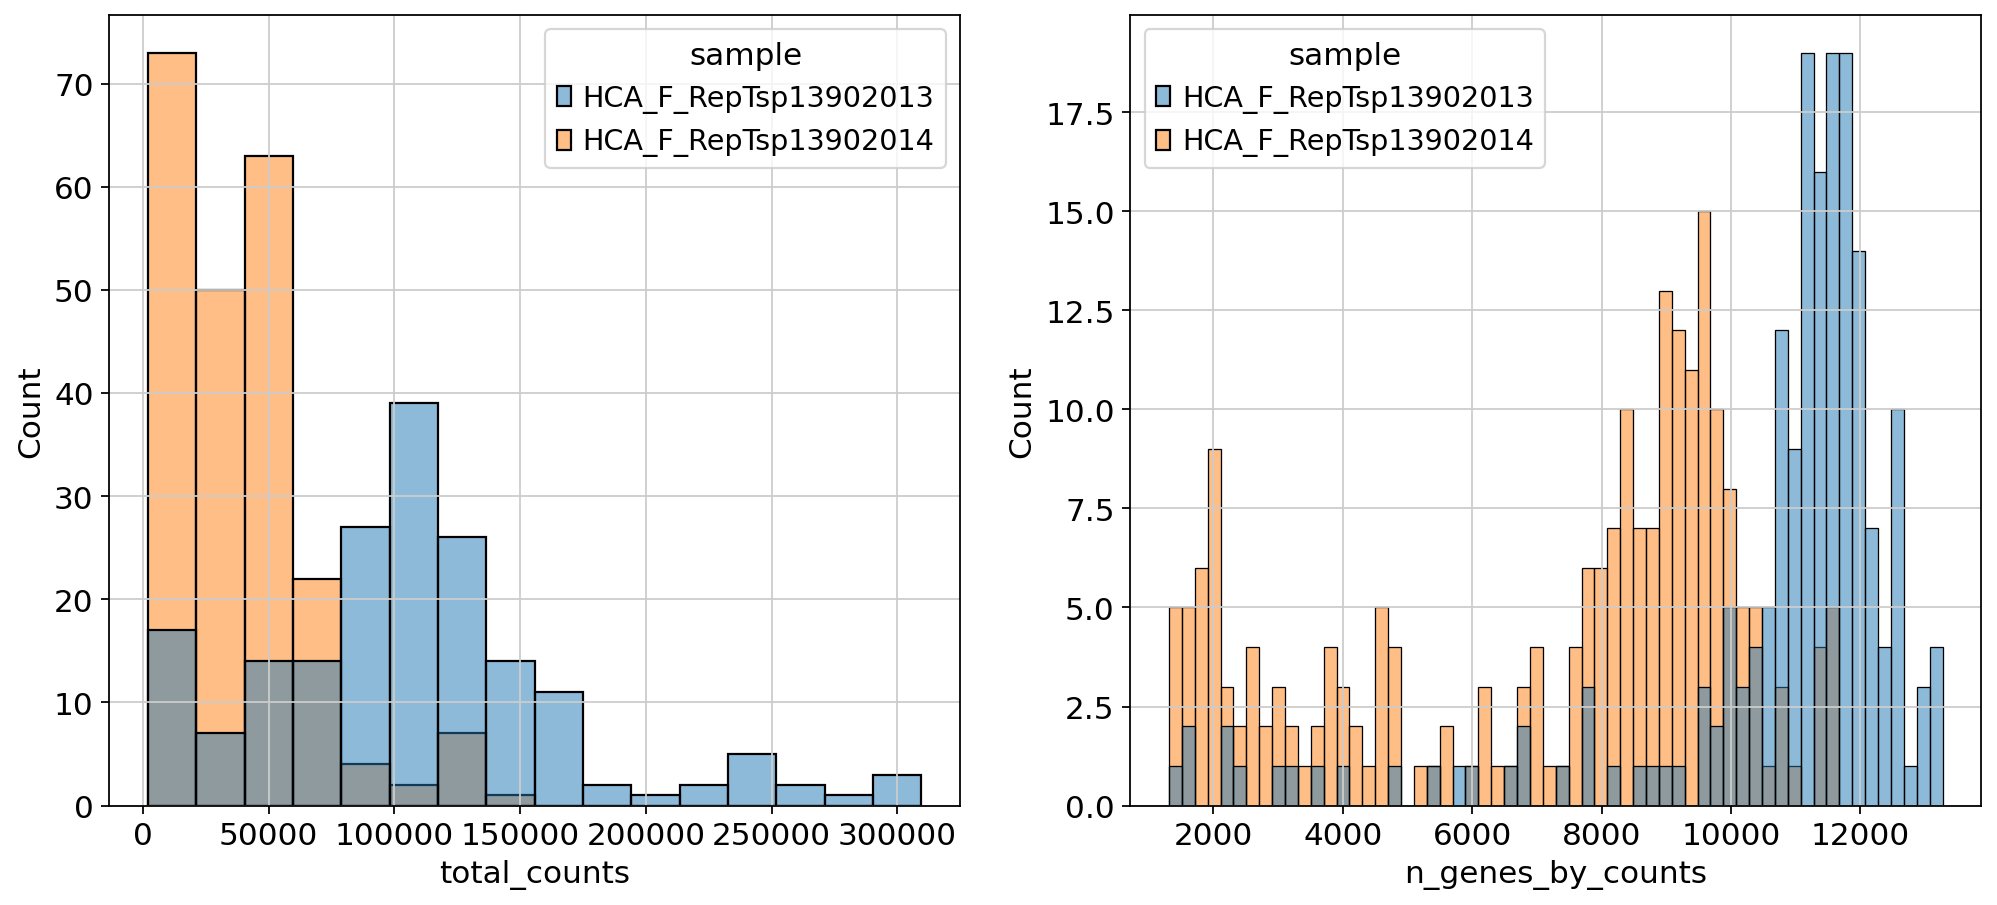

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6.5))
sns.histplot(overlap.obs, x = overlap.obs["total_counts"], hue = overlap.obs["sample"], kde=False, ax=axs[0])
sns.histplot(overlap.obs, x = overlap.obs["n_genes_by_counts"], hue = overlap.obs["sample"], kde=False, bins=60, ax=axs[1])


In [10]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                         frameon=True, vector_friendly=True, fontsize=14, figsize=[6,6], color_map=None, 
                         format='pdf', facecolor=None, transparent=False)

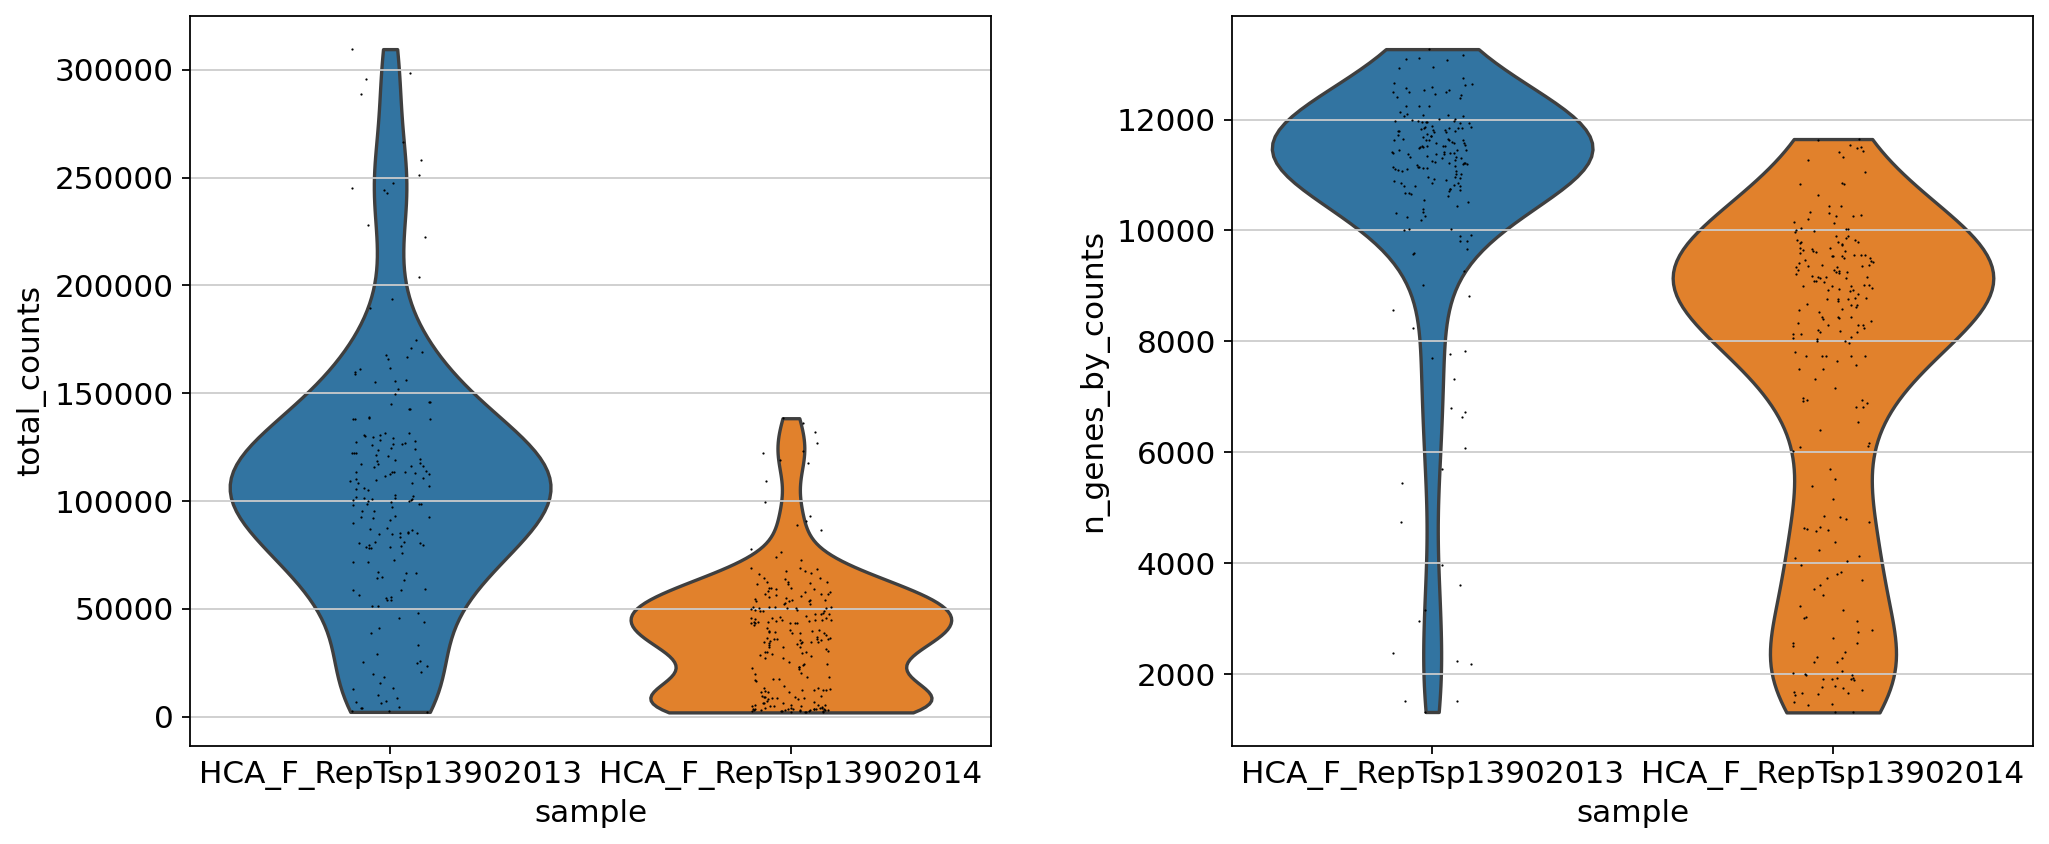

In [11]:
sc.pl.violin(overlap, ['total_counts', 'n_genes_by_counts'], groupby = 'sample', multi_panel = True)

### What are scale factors?

In single-cell RNA sequencing (scRNA-seq), **scale factors are normalization factors used to adjust for differences in sequencing depth across cells**.

When performing scRNA-seq, the number of transcripts captured can vary across cells due to technical factors such as variation in *cell lysis efficiency*, *cDNA synthesis efficiency*, and *sequencing depth*. This can result in differences in the number of sequencing reads obtained for each cell, which can confound downstream analyses. To address this issue, scale factors are used to adjust the read counts for each cell by a constant factor so that the total number of reads across all cells is equal.

Scanpy uses the **total-count normalization** method to compute scale factors. The total-count normalization method *assumes that the majority of genes are not differentially expressed between cells and adjusts for differences in sequencing depth by scaling the count data to a common library size*. The **scaling factor for each cell is the total count divided by the median count across all cells**.

The rationale for using the median instead of the mean to compute the normalization factor is to avoid bias from highly expressed genes that may be present in only a few cells.

### 3. Derive scale factors from overlapping spots 

Since we have a dataset where some cells/spots have "duplicated" measurements from two experiments, we can use the duplicated measurements to derive scale factors that can be applied to the other cells in the dataset. The basic idea is to use the duplicated measurements to estimate the technical variation between the two experiments and use this estimate to normalize the data.

One approach would be to use the duplicated measurements to **fit a linear regression model that relates the log-expression values of the *duplicated* cells/spots from the two experiments**. The **exp(slope) of the regression line provides an estimate of the technical variation between the two experiments**, which can be used as a scale factor to normalize the other cells.

The reason for exponentiating the slopes is that the slope in the log space is equivalent to the fold change between the two conditions. Exponentiating the slope yields the ratio of expression levels between the two conditions on a linear scale. Therefore, by exponentiating the slopes, we obtain a factor that can be directly used to rescale the data to the same scale, making it comparable between samples.

Basically, exponentiating the slopes is a convenient way to convert the fold change between conditions, which is measured on a logarithmic scale, to a linear scale that can be directly used as a normalization factor for the data.

In [12]:
import numpy as np

In [13]:
import json
with open("HCA_F_RepTsp13902013_14_overlapping_barcodes.json", "r") as f:
    overlapping_barcodes = json.load(f)

In [14]:
overlap

AnnData object with n_obs × n_vars = 407 × 15824
    obs: 'sample', 'batch', 'in_tissue', 'array_row', 'array_col', 'overlaps_with', 'is_overlap', 'in_tissue_and_is_overlap', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors', 'spatial'
    obsm: 'spatial'

Record the pairs of overlapping spots 

In [15]:
import numpy as np

In [16]:
spot_pairs = {}
for k, v in overlapping_barcodes.items():
    if (k in overlap.obs_names.to_list()) & (v in overlap.obs_names.to_list()):
        barcode1_idx = np.where(overlap.obs_names == k)[0][0]
        barcode2_idx = np.where(overlap.obs_names == v)[0][0]
        
        spot_pairs[barcode1_idx] = barcode2_idx

Log transform the raw counts

In [17]:
log_counts = sc.pp.log1p(overlap, copy = True)

In [18]:
log_counts.X[list(spot_pairs.keys())].toarray().shape

(181, 15824)

In [19]:
log_counts.X[list(spot_pairs.values())].toarray().shape

(181, 15824)

In [20]:
from scipy.stats import linregress

Compute the slope of the regression line for each gene and record genes for which we can compute the slope (i.e. non-zero expression in duplicated spots)

In [21]:
slopes = []
genes = []
i = 0
for gene_counts in log_counts.X.toarray().T:
    x = gene_counts[list(spot_pairs.keys())]
    y = gene_counts[list(spot_pairs.values())]
    if (np.sum(x) != 0) & (np.sum(y) != 0):
        slope, _, _, _, _ = linregress(x, y)
        slopes.append(slope)
        genes.append(i)
        i += 1


In [22]:
len(slopes)

15648

In [23]:
len(genes)

15648

Exponentiate the slopes (which were calculated in log-transformed space) to obtain the scale factors

In [24]:
scale_factors = np.exp(slopes)

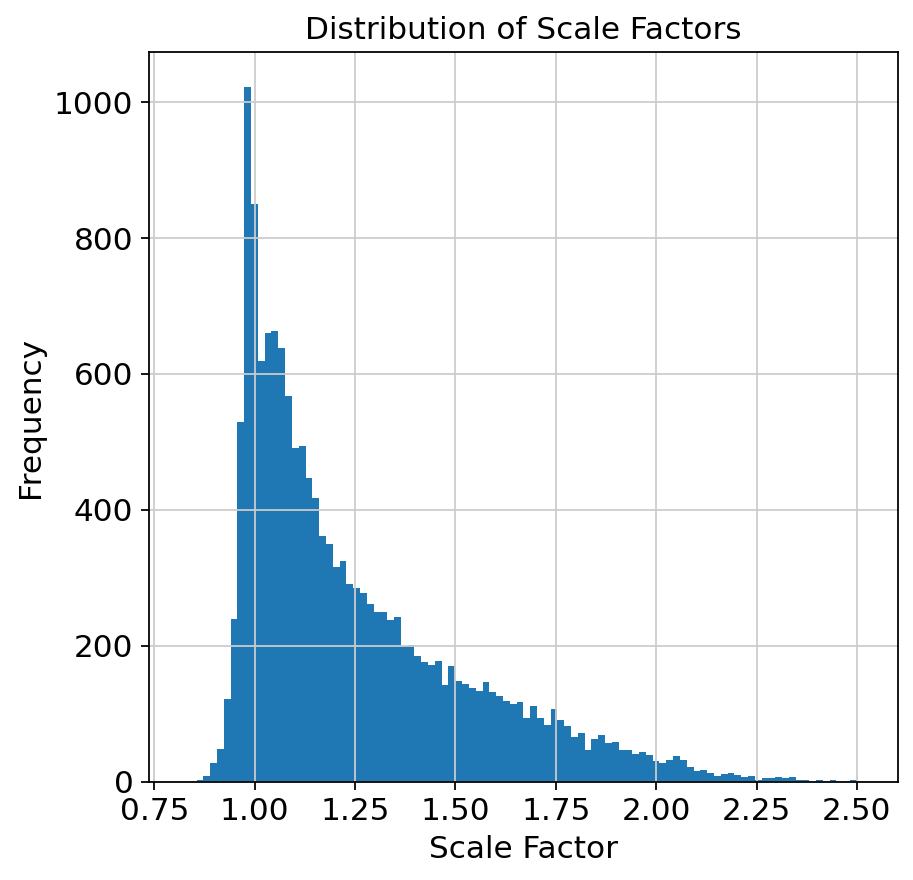

In [25]:
# Plot scale factors 
plt.hist(scale_factors, bins=100)
plt.xlabel('Scale Factor')
plt.ylabel('Frequency')
plt.title('Distribution of Scale Factors')
plt.show()

Good to see that the majority of genes have scale factor of 1, meaning perfect correspondence between the gene expression in overlapping spots

In [26]:
# Record the genes that were used to compute scale factors 
genes_scale_factors = overlap[:, genes].var_names

In [27]:
# Record the overlapping spots 
spots_overlap = overlap[list(spot_pairs.keys()) + (list(spot_pairs.values())), :].obs_names

In [28]:
spots_overlap_13 = overlap[list(spot_pairs.keys())].obs_names

In [29]:
spots_overlap_14 = overlap[list(spot_pairs.values())].obs_names

### Plot average expression of genes vs scale factors 

In [30]:
# Calculate average expression of each gene across all cells
import pandas as pd
overlap_plot = overlap[:, genes_scale_factors]
avg_exp = overlap_plot.X.mean(axis=0)

In [31]:
# Convert the average expression to a pandas dataframe
df_avg_exp = pd.DataFrame(data=avg_exp.A1, index=overlap_plot.var_names, columns=['avg_expression'])
df_avg_exp.head()

avg_expression
ENSEMBL                        
ENSG00000187634        2.491397
ENSG00000188976        3.518423
ENSG00000187961        0.117936
ENSG00000187583        0.066339
ENSG00000187642        0.024570

In [32]:
# Add scale factors 
df_avg_exp['scale_factors'] = scale_factors

In [33]:
df_avg_exp.head()

avg_expression  scale_factors
ENSEMBL                                       
ENSG00000187634        2.491397       1.277049
ENSG00000188976        3.518423       1.136301
ENSG00000187961        0.117936       1.043417
ENSG00000187583        0.066339       0.995838
ENSG00000187642        0.024570       0.977402

In [34]:
# Sort the dataframe by average expression in ascending order
df_avg_exp_sorted = df_avg_exp.sort_values(by='avg_expression', ascending=True)
df_avg_exp_sorted.head()

avg_expression  scale_factors
ENSEMBL                                       
ENSG00000188959        0.012285       1.432911
ENSG00000188199        0.012285       1.232620
ENSG00000164123        0.012285       0.988166
ENSG00000109205        0.012285       0.988827
ENSG00000159648        0.012285       1.080108

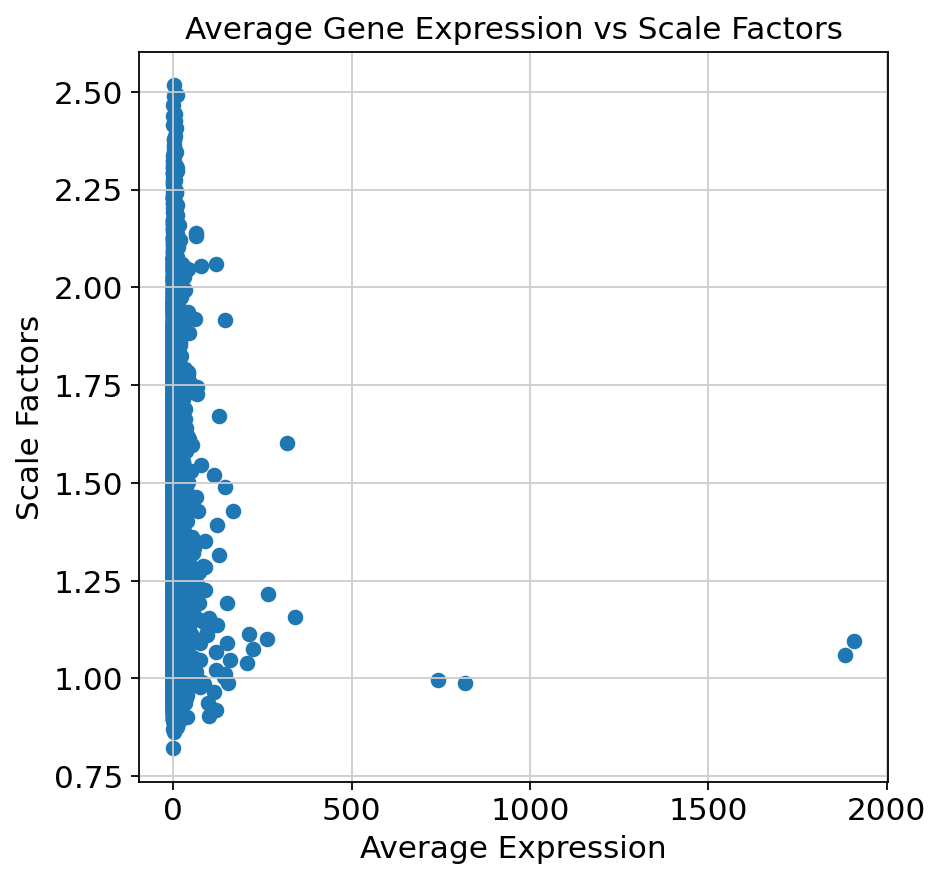

In [35]:
# Create scatterplot of mean expression versus scale factors for sorted genes
plt.scatter(df_avg_exp_sorted['avg_expression'], df_avg_exp_sorted['scale_factors'])
plt.xlabel('Average Expression')
plt.ylabel('Scale Factors')
plt.title('Average Gene Expression vs Scale Factors')
plt.show()

In [36]:
from scipy.stats import trim_mean

# Calculate the 10% trimmed median
trimmed_mean = trim_mean(scale_factors, 0.1)
trimmed_mean

1.2131603911337405

In [37]:
median = np.median(scale_factors)
median

1.1597116383660953

In [38]:
# Normalise overlapping spots from slide 19 and plot distribution of counts again for comparison 

# Create a mask for the barcodes to normalise
normalise_mask = np.isin(overlap_plot.obs.index, spots_overlap_14)

# Copy the original count matrix to a new matrix
normalised_counts = overlap_plot.X.copy()

# Normalise the counts for the selected barcodes
normalised_counts[normalise_mask] /= trimmed_mean

# Create a new anndata object with the normalised counts
import anndata
normalised_overlap = anndata.AnnData(X=normalised_counts, obs=overlap_plot.obs, var=overlap_plot.var)


In [39]:
for col in [ 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes']:
    del normalised_overlap.obs[col]

In [40]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(normalised_overlap, inplace=True)

<AxesSubplot: xlabel='n_genes_by_counts', ylabel='Count'>

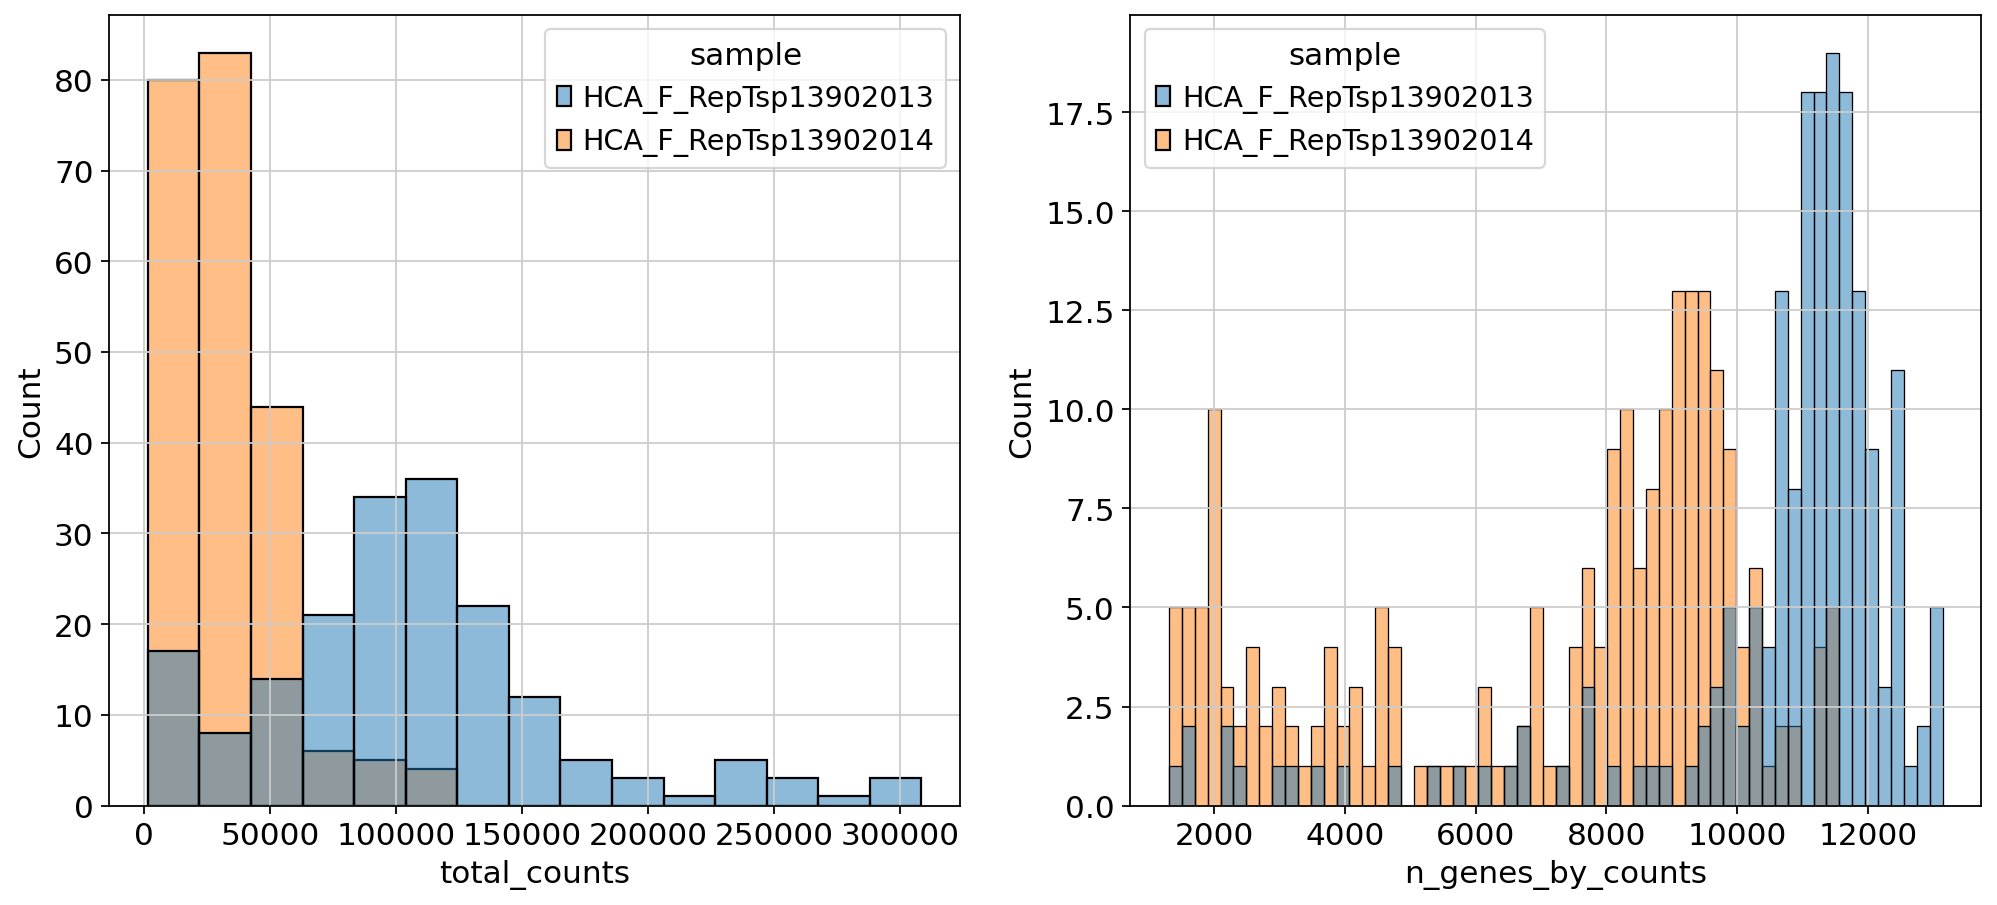

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6.5))
sns.histplot(normalised_overlap.obs, x = normalised_overlap.obs["total_counts"], hue = normalised_overlap.obs["sample"], kde=False, ax=axs[0])
sns.histplot(normalised_overlap.obs, x = normalised_overlap.obs["n_genes_by_counts"], hue = normalised_overlap.obs["sample"], kde=False, bins=60, ax=axs[1])

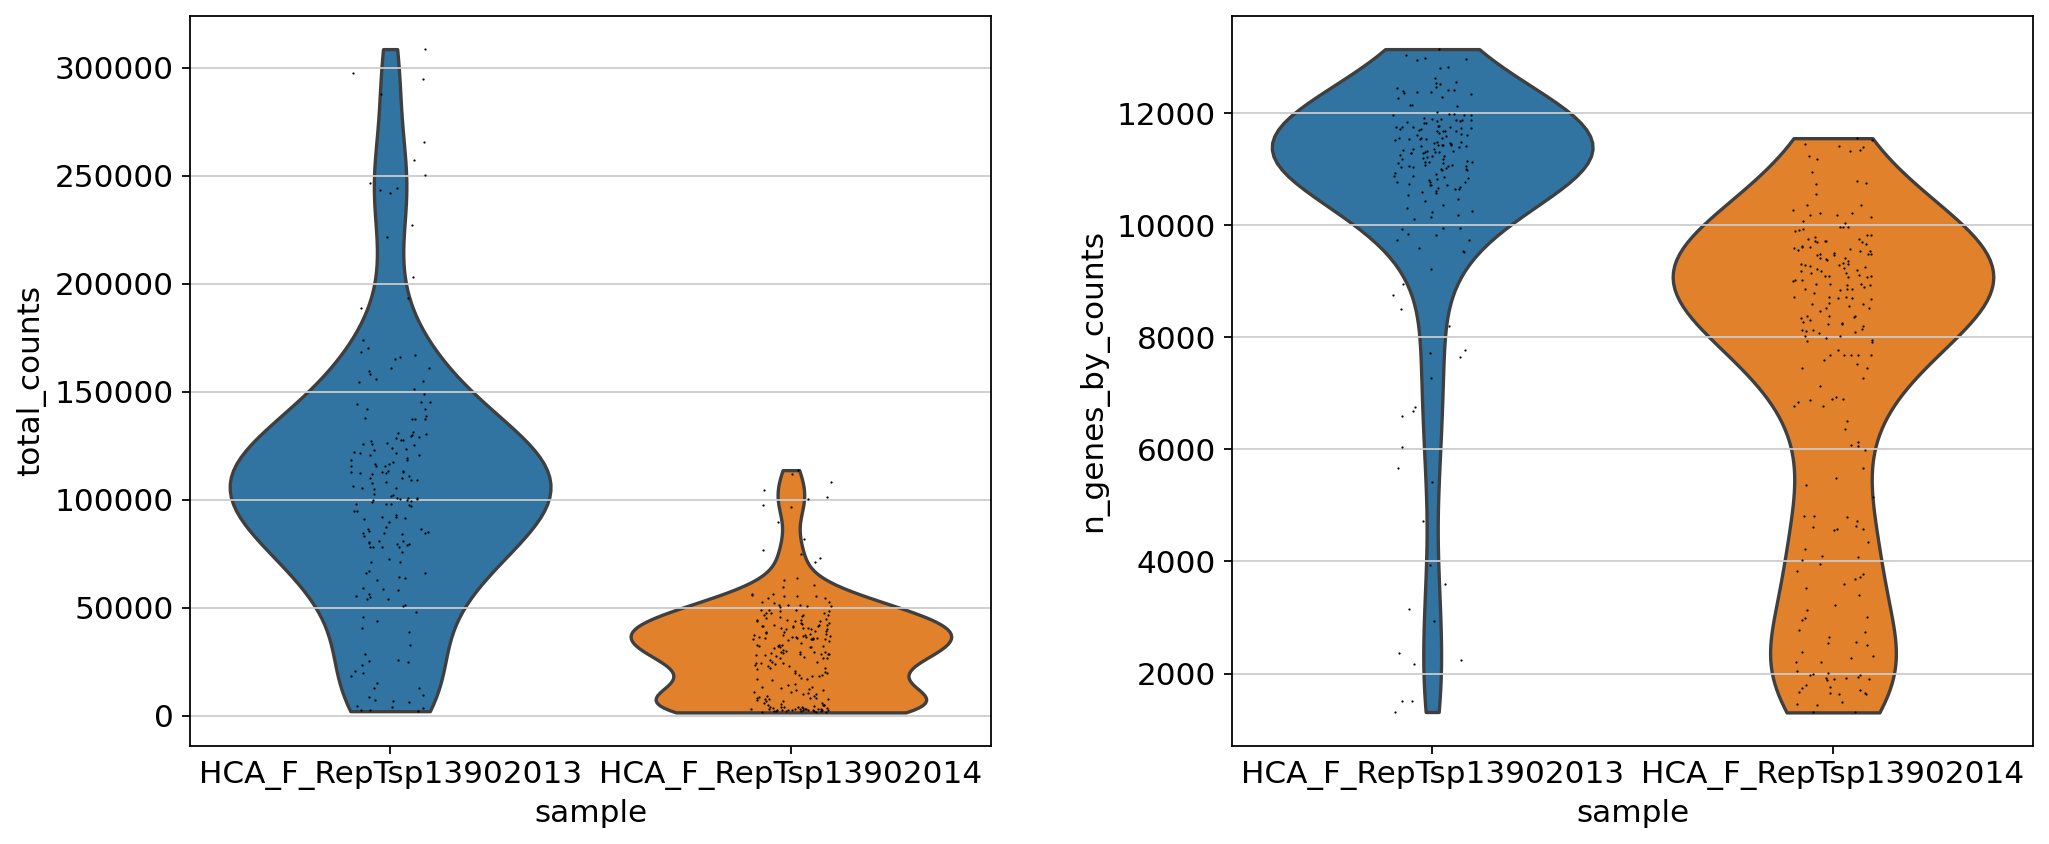

In [42]:
sc.pl.violin(normalised_overlap, ['total_counts', 'n_genes_by_counts'], groupby = 'sample', multi_panel = True)

### 4. Normalise all spots from slide 14 based on the scale factors computed from overlapping spots

In [43]:
spots_non_overlap = adata[[i not in spots_overlap.tolist() for i in adata.obs_names]].obs_names.to_list()
spots_non_overlap_13 = [i for i in spots_non_overlap if i.startswith('HCA_F_RepTsp13902013_')]
print('Non-overlapping spots from slide HCA_F_RepTsp13902013: {}'.format(len(spots_non_overlap_13)))
spots_non_overlap_14 = [i for i in spots_non_overlap if i.startswith('HCA_F_RepTsp13902014_')]
print('Non-overlapping spots from slide HCA_F_RepTsp13902014: {}'.format(len(spots_non_overlap_14)))


Non-overlapping spots from slide HCA_F_RepTsp13902013: 1366
Non-overlapping spots from slide HCA_F_RepTsp13902014: 2635


In [44]:
all_spots_14 = spots_overlap_14.to_list() + spots_non_overlap_14

In [45]:
len(all_spots_14)

2816

In [46]:
# Subset genes 
slide_14 = adata[:, genes_scale_factors]
slide_14 = slide_14[[i in all_spots_14 for i in slide_14.obs_names]]

In [47]:
slide_14

View of AnnData object with n_obs × n_vars = 2816 × 15648
    obs: 'sample', 'batch', 'in_tissue', 'array_row', 'array_col', 'overlaps_with', 'is_overlap', 'in_tissue_and_is_overlap'
    var: 'feature_types', 'genome', 'SYMBOL'
    uns: 'sample_colors', 'spatial'
    obsm: 'spatial'

In [48]:
# Normalize count data by scale factors
slide_14.X = slide_14.X / trimmed_mean

In [49]:
slide_14.X.toarray()[20:30, 20:30]

array([[  5.7700534,   0.       ,   5.7700534,  23.080214 ,   4.94576  ,
         55.227654 ,   0.       ,   7.4186397,   0.       ,   0.       ],
       [  0.8242933,   0.       ,   0.       ,   4.1214666,   0.       ,
         24.7288   ,   0.       ,   3.2971733,   0.       ,   0.8242933],
       [  4.94576  ,   0.       ,   0.8242933,   8.242933 ,   3.2971733,
         65.94347  ,   0.       ,   4.94576  ,   0.       ,   0.8242933],
       [  0.8242933,   0.       ,   2.47288  ,   3.2971733,   1.6485866,
          9.89152  ,   0.       ,   2.47288  ,   0.       ,   2.47288  ],
       [  3.2971733,   0.       ,   2.47288  ,  27.20168  ,   2.47288  ,
         39.56608  ,   1.6485866,  16.485867 ,   0.       ,   1.6485866],
       [  0.8242933,   0.       ,   0.8242933,   2.47288  ,   0.       ,
         23.904507 ,   1.6485866,   0.       ,   0.       ,   0.8242933],
       [  1.6485866,   0.8242933,   5.7700534,   3.2971733,   2.47288  ,
         55.227654 ,   1.6485866,   3.2971733

### 5. Concatenate normalised slide 14 with non-overlapping spots of slide 13

In [50]:
slide_13 = adata[:, genes_scale_factors]
slide_13 = slide_13[[i in spots_non_overlap_13 for i in slide_13.obs_names]]
slide_13

View of AnnData object with n_obs × n_vars = 1366 × 15648
    obs: 'sample', 'batch', 'in_tissue', 'array_row', 'array_col', 'overlaps_with', 'is_overlap', 'in_tissue_and_is_overlap'
    var: 'feature_types', 'genome', 'SYMBOL'
    uns: 'sample_colors', 'spatial'
    obsm: 'spatial'

In [51]:
slide_13.X.toarray()[20:30, 20:30]

array([[  3.,   0.,   6.,  12.,   2.,  25.,   0.,   9.,   0.,   2.],
       [  5.,   0.,   8.,  26.,   4.,  50.,   0.,   6.,   0.,   2.],
       [  2.,   0.,   2.,   9.,   8.,  61.,   6.,  18.,   0.,   5.],
       [  1.,   1.,   7.,  16.,   7.,  53.,   0.,   7.,   2.,   3.],
       [  4.,   0.,   4.,  27.,   8.,  82.,   4.,   8.,   2.,   4.],
       [  2.,   0.,   4.,  10.,   0.,  21.,   0.,   8.,   1.,   1.],
       [  6.,   1.,   3.,  26.,   3.,  65.,   1.,  13.,   0.,   5.],
       [  4.,   0.,   1.,  28.,   2.,  37.,   0.,   2.,   0.,   6.],
       [  2.,   0.,   6.,  31.,   3.,  47.,   0.,   5.,   0.,   2.],
       [  6.,   0.,   7.,  14.,  14., 103.,   2.,  19.,   0.,   2.]],
      dtype=float32)

In [52]:
res = slide_13.concatenate(slide_14, index_unique=None)
res

/opt/conda/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 4182 × 15648
    obs: 'sample', 'batch', 'in_tissue', 'array_row', 'array_col', 'overlaps_with', 'is_overlap', 'in_tissue_and_is_overlap'
    var: 'feature_types', 'genome', 'SYMBOL'
    obsm: 'spatial'

In [53]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(res, inplace=True)

<AxesSubplot: xlabel='n_genes_by_counts', ylabel='Count'>

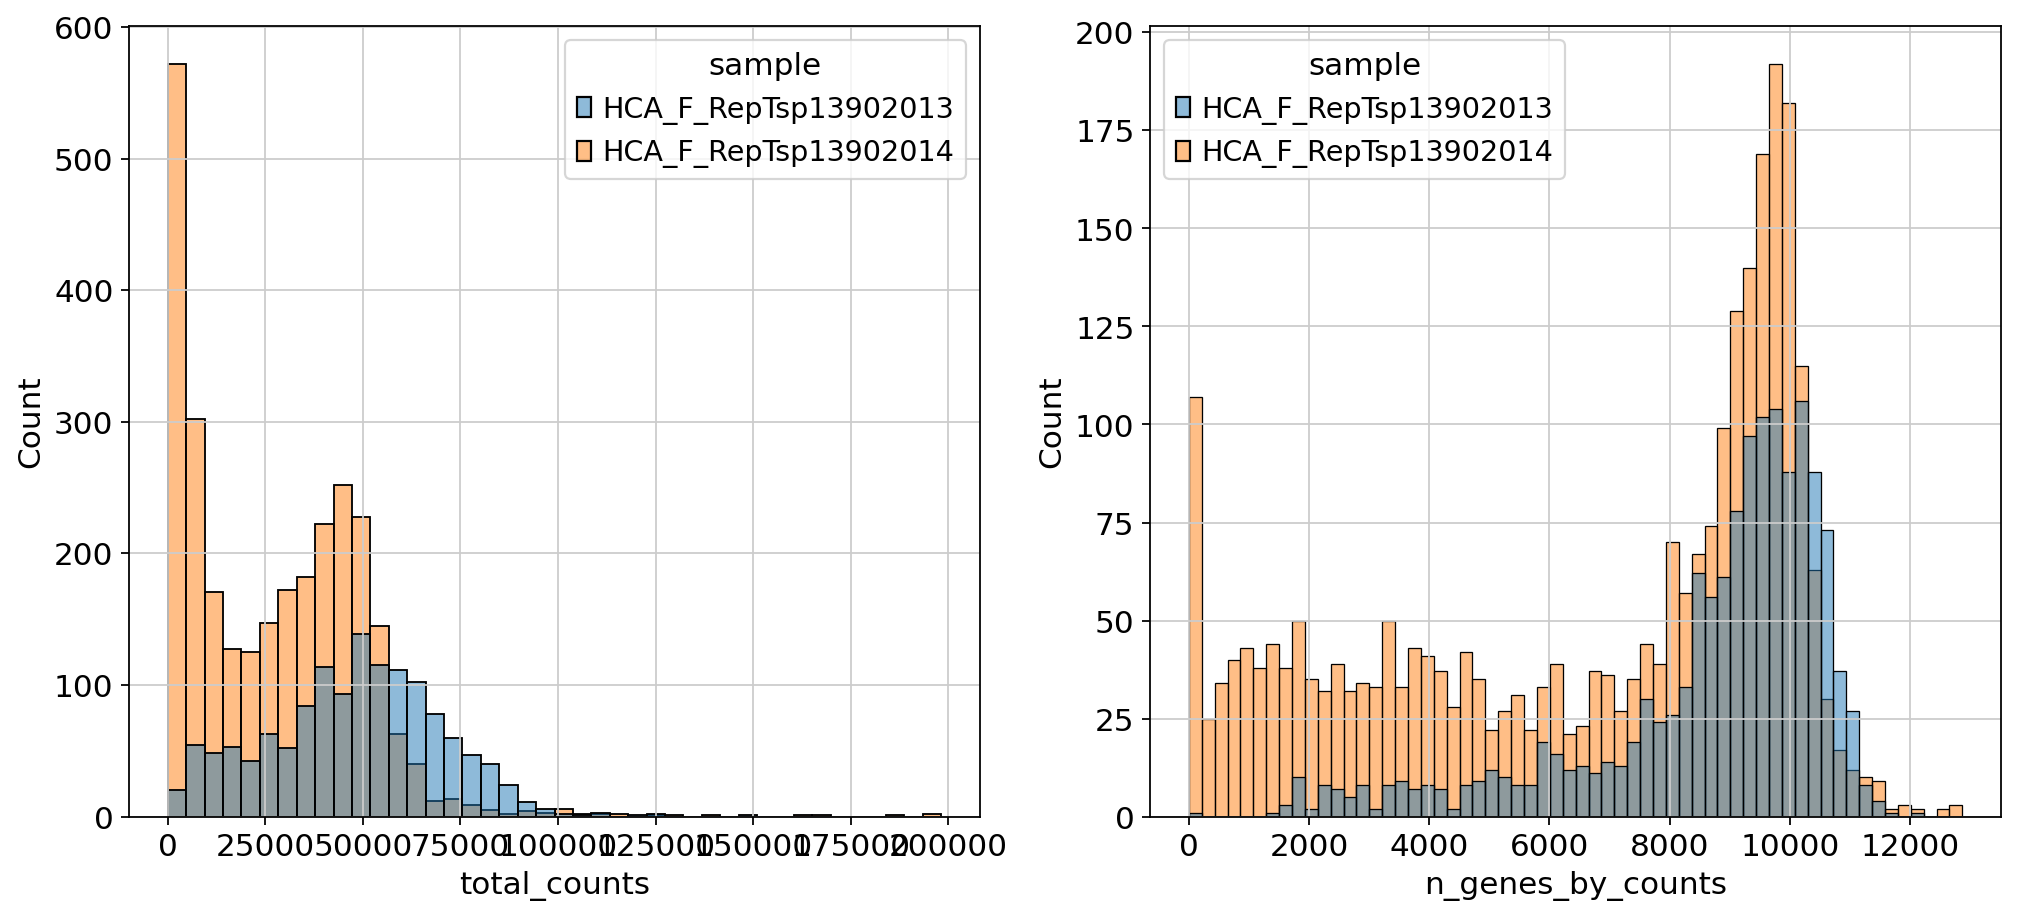

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6.5))
sns.histplot(res.obs, x = res.obs["total_counts"], hue = res.obs["sample"], kde=False, ax=axs[0])
sns.histplot(res.obs, x = res.obs["n_genes_by_counts"], hue = res.obs["sample"], kde=False, bins=60, ax=axs[1])

In [55]:
res.raw = res.copy()

In [56]:
sc.pp.normalize_total(res, target_sum=1e4, exclude_highly_expressed = True)

sc.pp.log1p(res)
sc.pp.highly_variable_genes(res, min_mean=0.0125, max_mean=3, min_disp=0.5)
res

/opt/conda/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 4182 × 15648
    obs: 'sample', 'batch', 'in_tissue', 'array_row', 'array_col', 'overlaps_with', 'is_overlap', 'in_tissue_and_is_overlap', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

In [57]:
np.max(res.X.toarray())

9.7103195

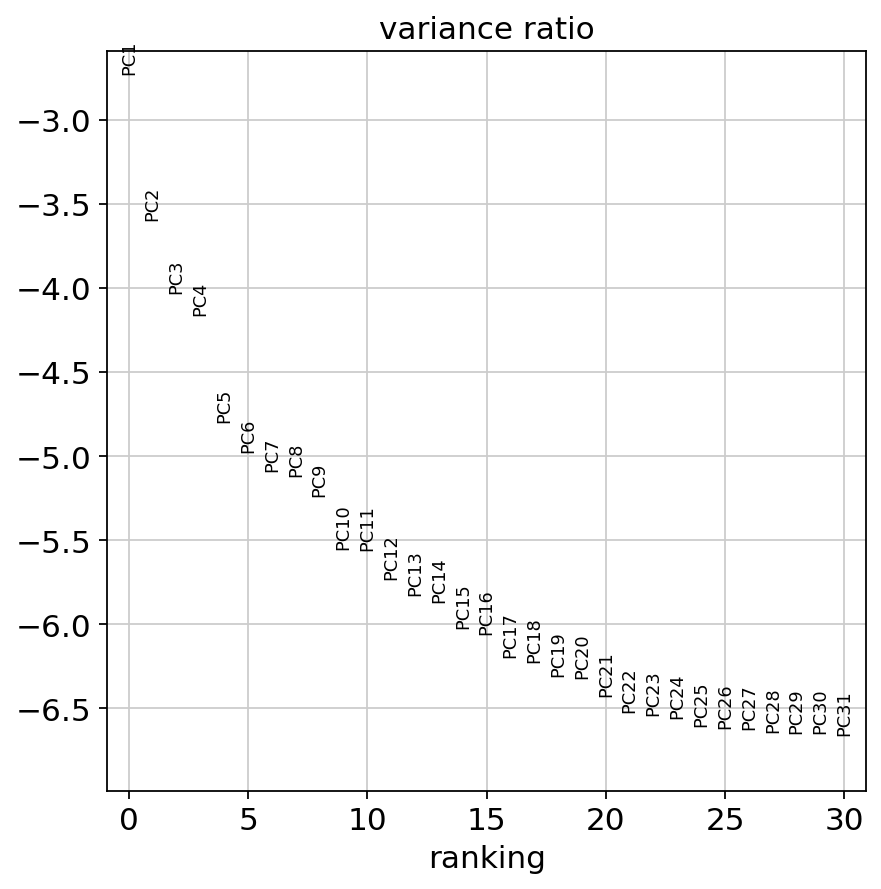

In [58]:
sc.pp.scale(res, max_value=10)
sc.tl.pca(res, svd_solver='arpack')
sc.pl.pca_variance_ratio(res, log=True)

In [59]:
np.max(res.X)

10.0

In [60]:
# Re-add spatial info 
res.uns["spatial"] = dict()
library_id = "joint"
res.uns["spatial"][library_id] = dict()

In [61]:
from matplotlib.image import imread

res.uns["spatial"][library_id]['images'] = dict()
res.uns["spatial"][library_id]['images']["hires"] = imread("HCA_F_RepTsp13902013_14_tissue_hires_image.png")

In [62]:
import json

with open("/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902013/spatial/scalefactors_json.json", "r") as fid:
    res.uns["spatial"][library_id]['scalefactors'] = json.load(fid)

In [63]:
import pandas as pd

p1 = pd.read_csv("HCA_F_RepTsp13902013_tissue_positions_list.csv", header=None)
p2 = pd.read_csv("HCA_F_RepTsp13902014_tissue_positions_list.csv", header=None)

In [64]:
p1.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]

p1.index = p1['barcode']

p2.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]

p2.index = p2['barcode']


In [65]:
positions = pd.concat([p1, p2])
positions.drop(columns=['in_tissue', 'array_row', 'array_col'],
    inplace=True)
res.obs['barcode'] = res.obs_names
res.obs = res.obs.join(positions, how="inner", on = 'barcode', lsuffix = 'L')
res.obsm['spatial'] = res.obs[
    ['pxl_row_in_fullres', 'pxl_col_in_fullres']
].to_numpy()
spatial = res.obsm['spatial'].copy()
res.obsm['spatial'][:,0] = spatial[:,1]
res.obsm['spatial'][:,1] = spatial[:,0]

In [66]:
res

AnnData object with n_obs × n_vars = 4182 × 15648
    obs: 'sample', 'batch', 'in_tissue', 'array_row', 'array_col', 'overlaps_with', 'is_overlap', 'in_tissue_and_is_overlap', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'barcodeL', 'barcode', 'pxl_col_in_fullres', 'pxl_row_in_fullres'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'spatial'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

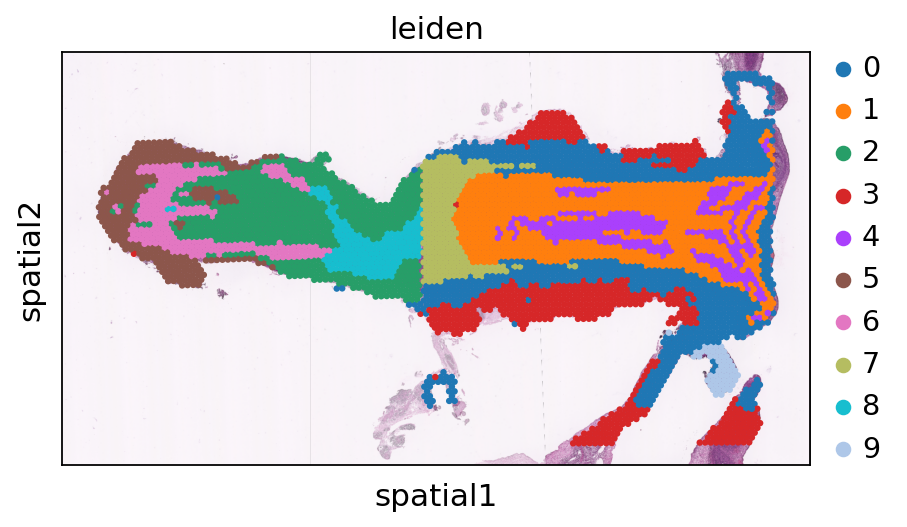

In [67]:
sc.pp.neighbors(res, n_pcs=12)
sc.tl.leiden(res, resolution = 0.2)
sc.pl.spatial(res, color="leiden")

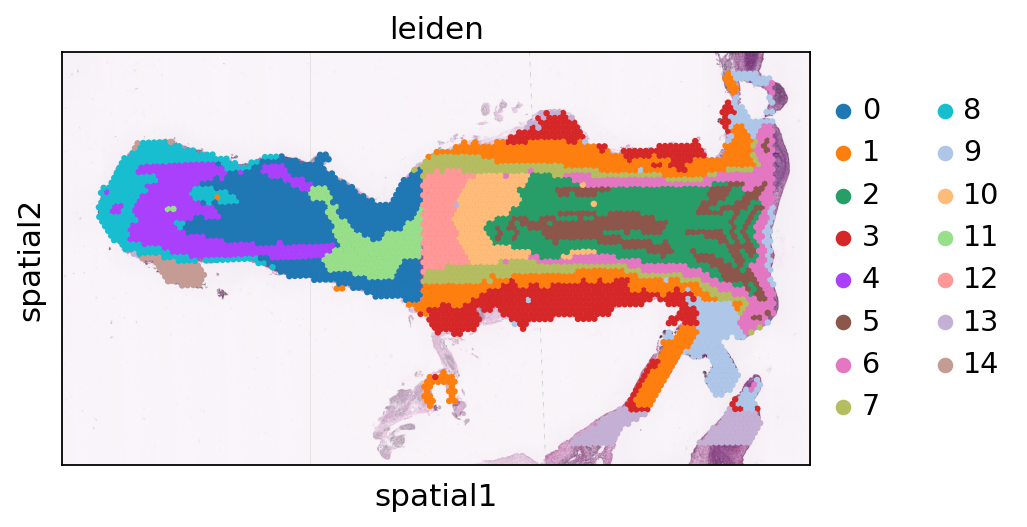

In [68]:
sc.tl.leiden(res, resolution=0.4)
sc.pl.spatial(res, color="leiden")

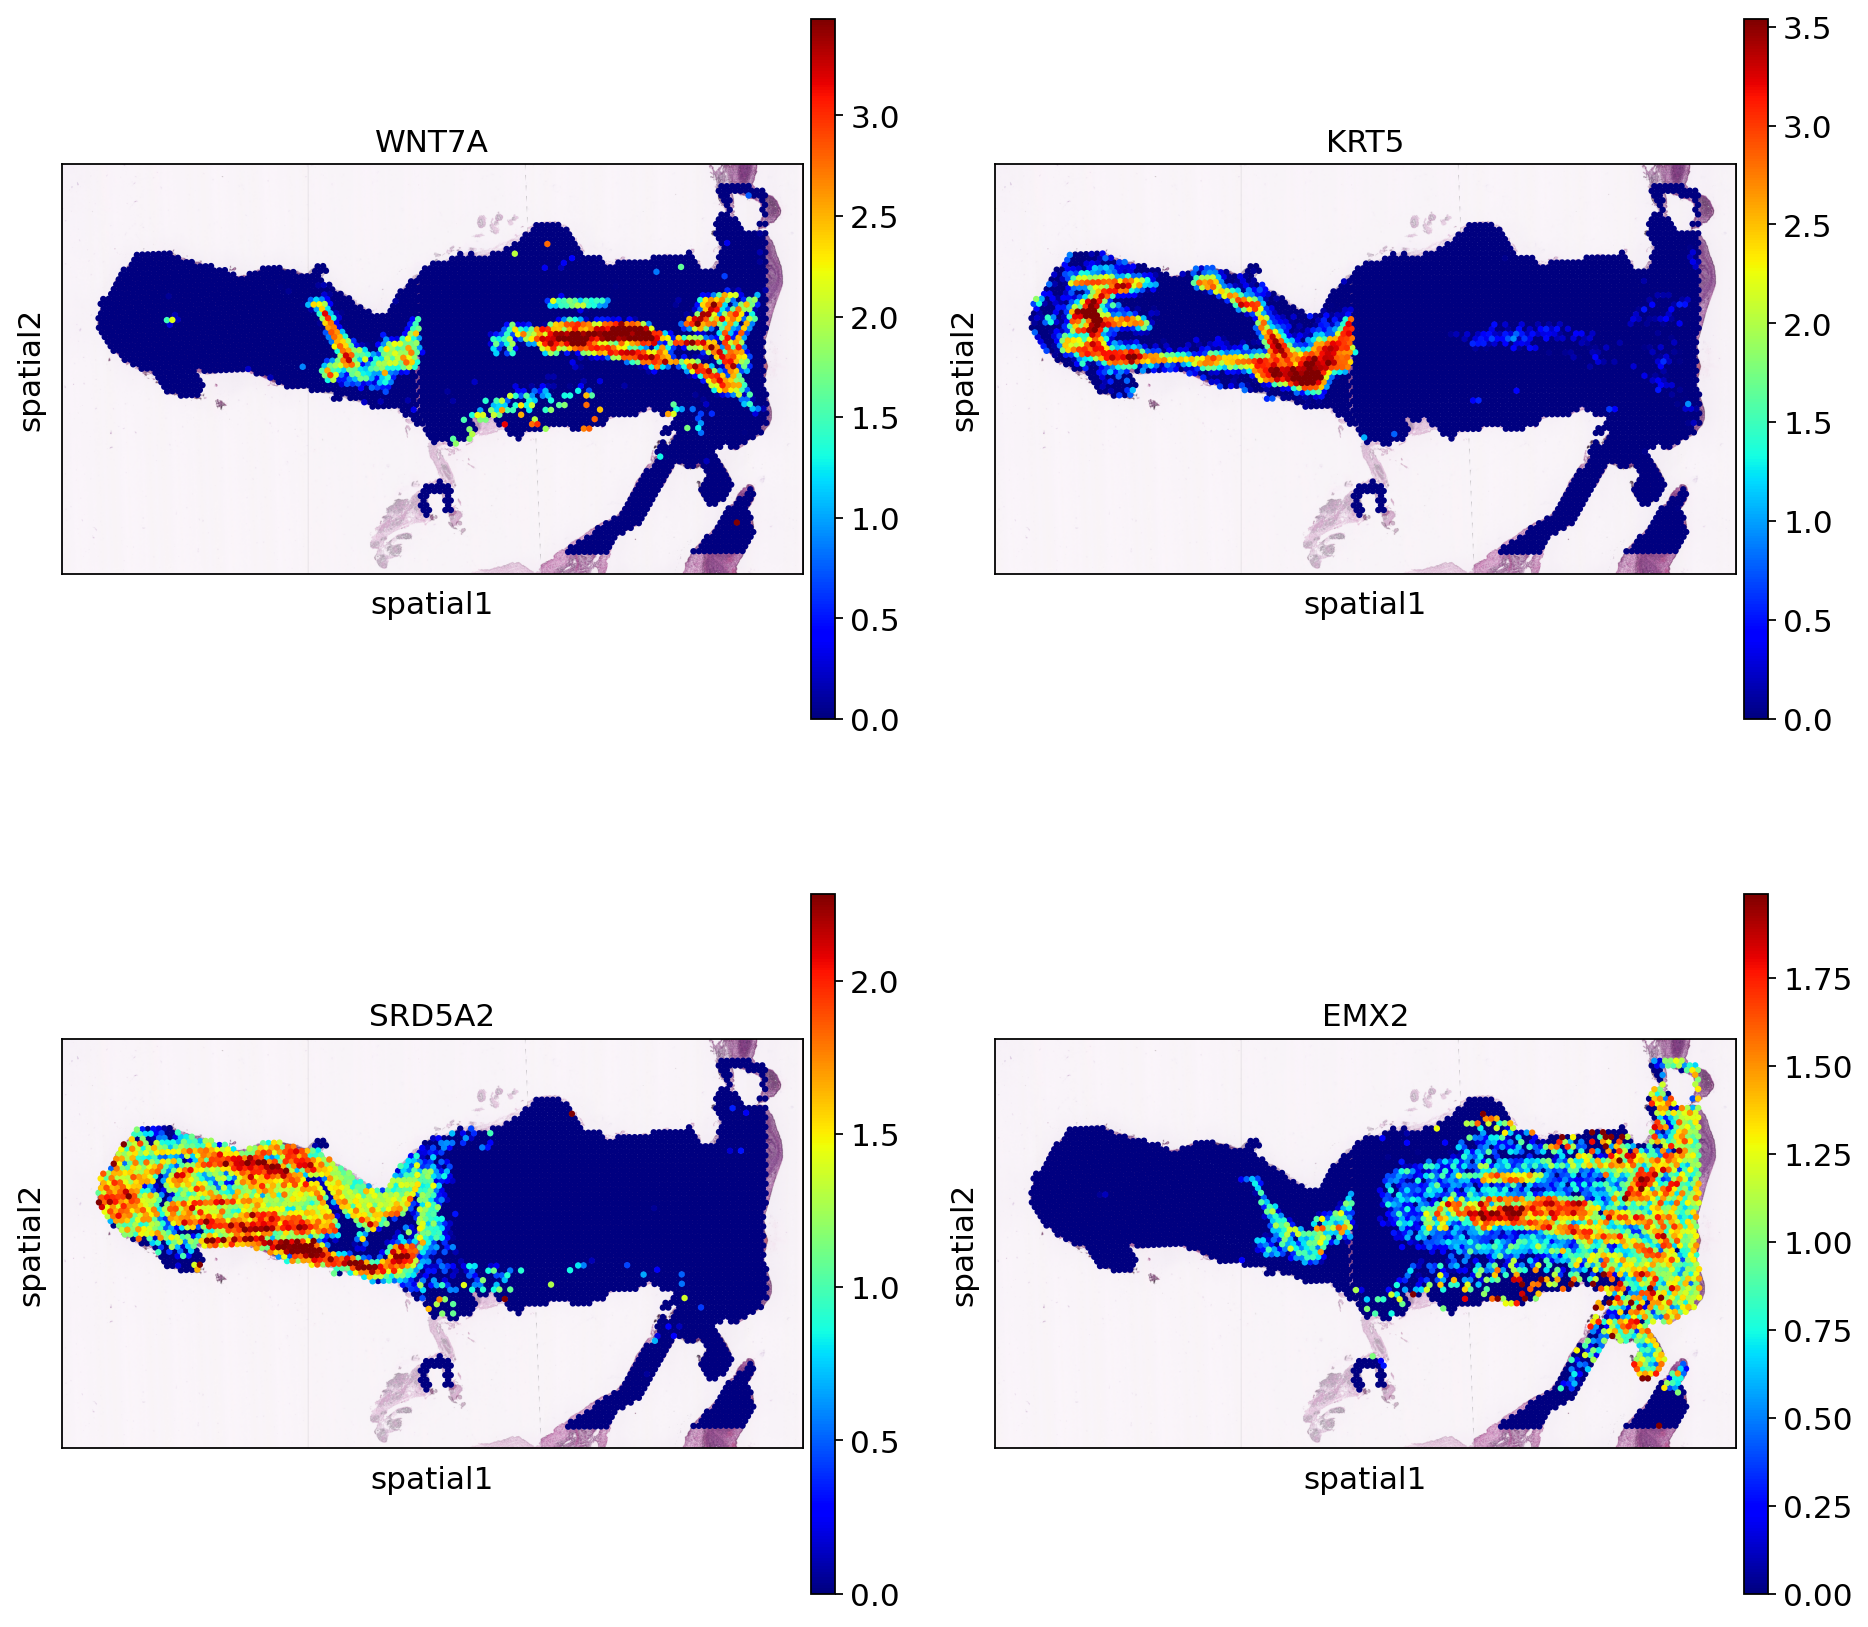

In [74]:
sc.pl.spatial(res, color=['WNT7A', 'KRT5', 'SRD5A2', 'EMX2'], gene_symbols = 'SYMBOL', ncols = 2, 
             cmap = 'jet', use_raw = False, vmin=0, vmax='p99.2')

/opt/conda/envs/imagespot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


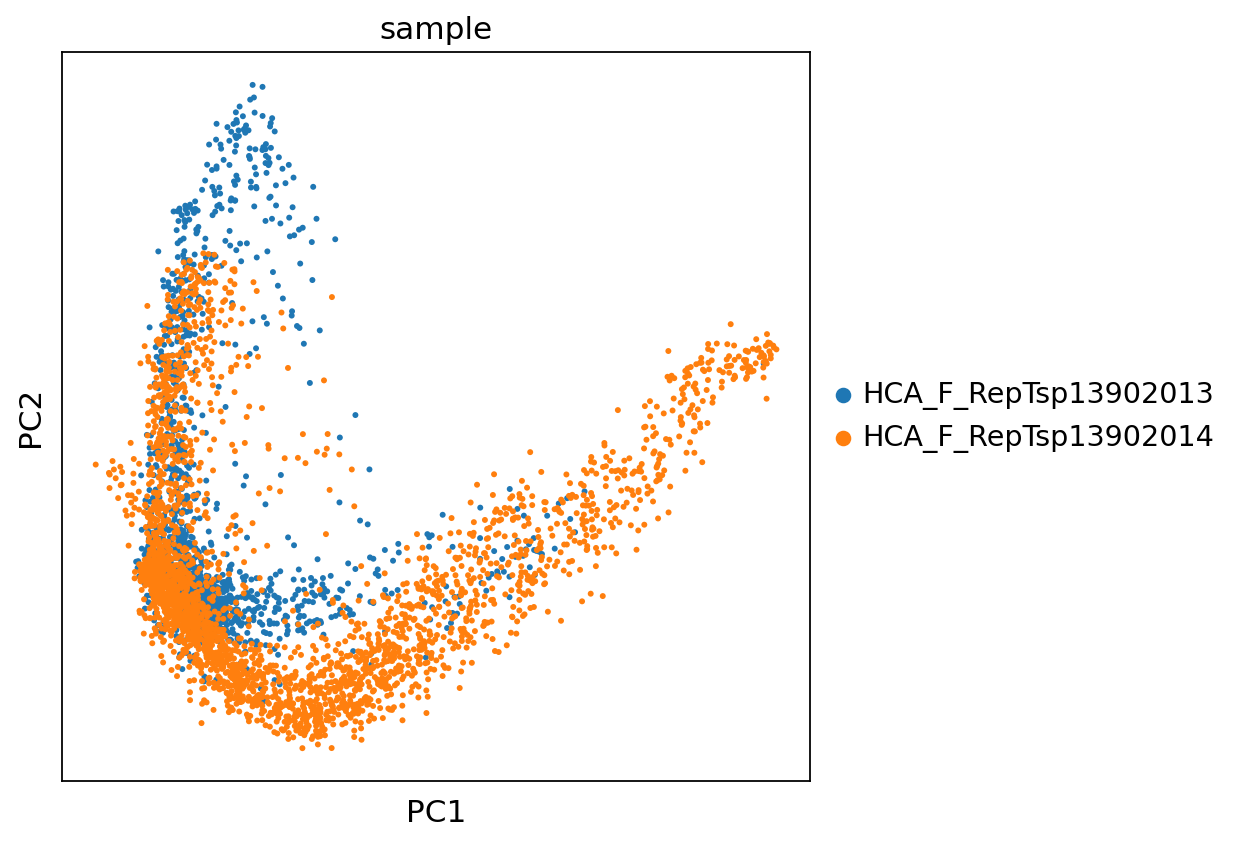

In [70]:
sc.pl.pca(res, color = 'sample')

/opt/conda/envs/imagespot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


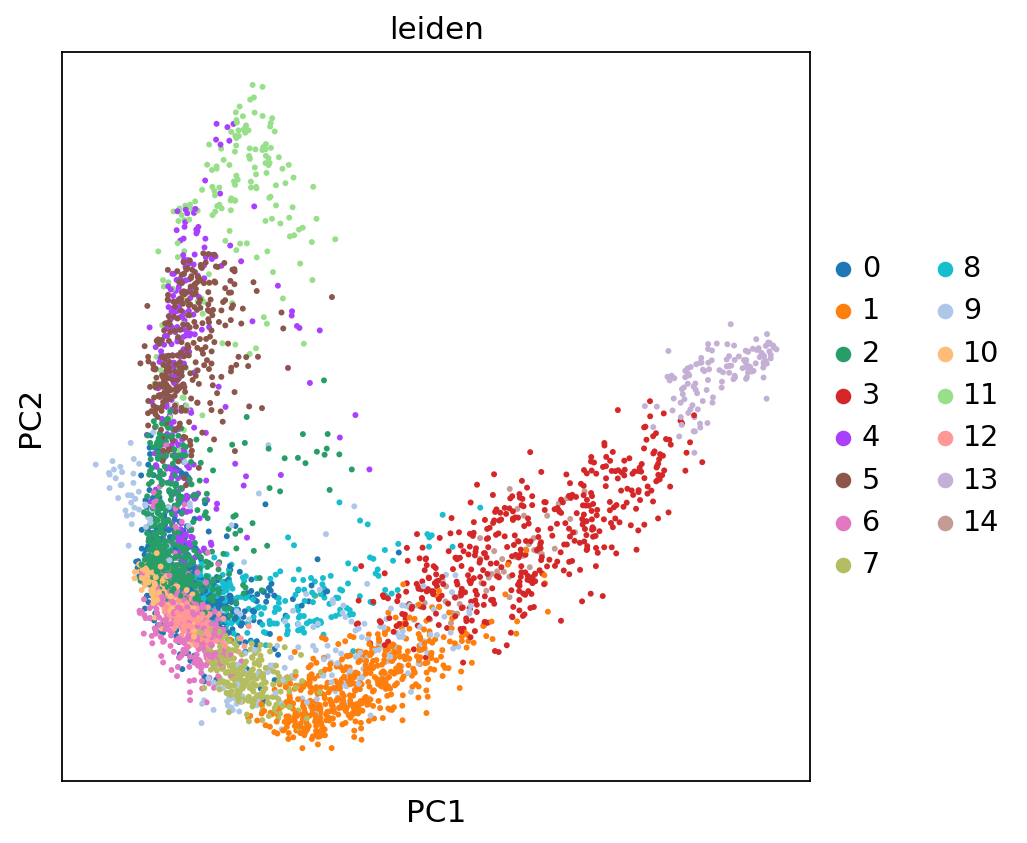

In [71]:
sc.pl.pca(res, color = 'leiden')

In [75]:
res.write('/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902013_HCA_F_RepTsp13902014/HCA_F_RepTsp13902013_HCA_F_RepTsp13902014_visium.h5ad')


In [76]:
res = sc.read('/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902013_HCA_F_RepTsp13902014/HCA_F_RepTsp13902013_HCA_F_RepTsp13902014_visium.h5ad')
res

AnnData object with n_obs × n_vars = 4182 × 15648
    obs: 'sample', 'batch', 'in_tissue', 'array_row', 'array_col', 'overlaps_with', 'is_overlap', 'in_tissue_and_is_overlap', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'barcodeL', 'barcode', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'leiden'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'spatial'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'